# Starting with lots of data and a good understanding of that data from *lifespan_of_companies*, we'll make a function to put in an API that will return the probability of a company going out of business in the next 2 years.


## Step 1: get the data ready for analysis

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import elasticsearch
import elasticsearch.helpers
import collections
import re
import copy
import datetime
import math
from pandas.io.json import json_normalize
from nltk.stem import PorterStemmer
from collections import Counter
from sklearn.model_selection import train_test_split

In [2]:
# Data goes from Elasticsearch into Pandas:
es = elasticsearch.Elasticsearch()

data_to_load = elasticsearch.helpers.scan(
                    es,
                    query={"query": {"match_all": {}}},
                    index="ri_sos",
                    doc_type="corporate_data")

# Initialize a double ended queue
output_all = collections.deque()
# Extend deque with iterator
output_all.extend(data_to_load)
only_data = [item["_source"] for item in output_all]

df = json_normalize(only_data)
print(df.shape)

(43684, 23)


## Add needed variables and, using what we learned in `lifespan_of_companies`, delete bad data
### Our dependent variable is different for a survival analysis than it was in `lifespan_of_companies`. We need to include the logged time in business for both active & inactive companies, and keep track of whether companies are active or inactive.

In [3]:
# Convert date columns to the date format
df['InactiveDate'] = pd.to_datetime(df['InactiveDate']).dt.date
df['OrganisationDate'] = pd.to_datetime(df['OrganisationDate']).dt.date

In [4]:
# Find examples where 'time_in_business' is negative (entity disolved before being formed, which is impossible):
df.loc[df['InactiveDate'] != np.nan, 'time_in_business'] = (df['InactiveDate'] - df['OrganisationDate']).dt.days
weird_rows = df.loc[df.time_in_business < 0]
print(weird_rows.IDNumber)

3011     000000417
29616    000000417
30541    000002273
Name: IDNumber, dtype: object


In [5]:
# If manual inspection shows you should delete them, then delete negatives and 0s:
df.drop(df[df.time_in_business < 1].index, inplace=True)
print("Resulting shape:", df.shape)

Resulting shape: (43677, 24)


In [6]:
df.time_in_business.describe()

count    32455.000000
mean      3515.187829
std       4116.401240
min          1.000000
25%       1030.000000
50%       2120.000000
75%       4303.000000
max      61626.000000
Name: time_in_business, dtype: float64

In [7]:
# Some rows are missing OrganisationDate, which is a part of our dependent variable. Drop those rows.
print("Original shape:", df.shape)

df.drop(df[pd.isnull(df.OrganisationDate)].index, inplace=True)
print("Shape after drops:", df.shape)

Original shape: (43677, 24)
Shape after drops: (43658, 24)


In [8]:
# Our dependent variable for a survival analysis is the time in business, whether the entity
# has gone out of business or not. Assuming the data was pulled on 3/1/19:
df.loc[pd.isnull(df.InactiveDate), 'log_censored_tib'] = np.log((datetime.date(2019, 3, 1) - df['OrganisationDate']).dt.days)
df.loc[pd.notnull(df.InactiveDate), 'log_censored_tib'] = np.log((df['InactiveDate'] - df['OrganisationDate']).dt.days)

df.log_censored_tib.head()

0    8.133000
1    9.402695
2    9.809616
3    8.293049
4    7.459339
Name: log_censored_tib, dtype: float64

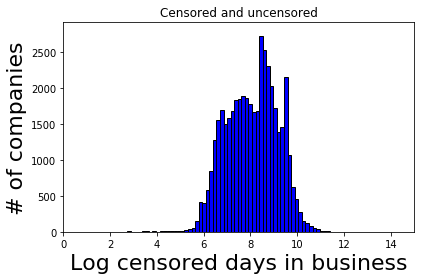

In [9]:
# Graph log_censored_time_in_business:
plt.hist(df.log_censored_tib, bins = 75,
         color = 'blue', edgecolor = 'black')
plt.axis([0, 15, 0, df.shape[0] / 15])
plt.xlabel('Log censored days in business', size = 22)
plt.ylabel('# of companies', size= 22)
plt.title('Censored and uncensored')

plt.tight_layout()
plt.show()

### This combined graph looks much less like a normal distribution than our prior graph of only entities that had gone out of business. Make a graph of the purely uncensored (entities still existing) data:

In [10]:
# 1 == the event (company became inactive), 0 == censored (not inactive as of 3/1/2019)
df['is_tib_censored'] = np.where(pd.notnull(df['InactiveDate']), 1, 0)

print("Inactive dates:", df.InactiveDate.head())
print("")
print("Censored conclusion:", df.is_tib_censored.head())

Inactive dates: 0    2005-10-07
1           NaT
2           NaT
3    1998-11-10
4    1989-09-21
Name: InactiveDate, dtype: object

Censored conclusion: 0    1
1    0
2    0
3    1
4    1
Name: is_tib_censored, dtype: int32


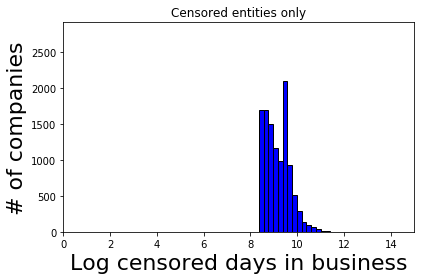

In [11]:
df_uncensored_only = df[df.is_tib_censored == 0]

plt.hist(df_uncensored_only.log_censored_tib, bins = 15,
         color = 'blue', edgecolor = 'black')
plt.axis([0, 15, 0, df.shape[0] / 15])
plt.xlabel('Log censored days in business', size = 22)
plt.ylabel('# of companies', size= 22)
plt.title('Censored entities only')

plt.tight_layout()
plt.show()

In [12]:
print("Most recently organized:", df.OrganisationDate.max())
print("Loggeg time_in_business for the most recently organized entity:",
      round(math.log((datetime.date(2019, 3, 1) - df.OrganisationDate.max()).days), 3))

Most recently organized: 2007-07-10
Loggeg time_in_business for the most recently organized entity: 8.355


### This makes sense. I pulled the data in 2019, but the data I was pulling from didn't include recently organized entities. Our uncensored data looks normally distributed, and it's reasonable to assume that our censored entities will become inactive following that same path.

### Make variables for the most common and meaningful words in entity's names

In [13]:
# Remove all punctuation from the names of companies
list_of_entity_names = [row[1] for row in df['EntityName'].iteritems()]

list_of_names_w_o_punctuation = []
for name in list_of_entity_names:
    list_of_names_w_o_punctuation += [re.sub('\,|\.|\!|\;|\:|\?|', '', name)]

# Break each name into a list of words so we can count the occurrence of each word
adjusted_words_in_entity_names = []
for words in list_of_names_w_o_punctuation:
    for word in words.split():
        adjusted_words_in_entity_names += [word.lower()]

# Count the occurrence of each word:
name_count = Counter(adjusted_words_in_entity_names)
popular_names = name_count.most_common(300)
print(popular_names[:10])

[('inc', 24187), ('llc', 8618), ('&', 3230), ('corporation', 2117), ('of', 2005), ('the', 1943), ('realty', 1774), ('company', 1732), ('associates', 1604), ('co', 1506)]


In [14]:
# Start by stemming entities names & descriptions. This makes words comparable across conjugations & forms,
# but at a cost of occasionally making the resulting word less intelligible.
stemmer = PorterStemmer()
list_of_stems = [stemmer.stem(word) for word in adjusted_words_in_entity_names]

# Count the occurrence of each word:
stemmed_name_count = Counter(list_of_stems)
stemmed_popular_names = stemmed_name_count.most_common(300)
print(stemmed_popular_names[:10])

[('inc', 24187), ('llc', 8619), ('&', 3230), ('associ', 2492), ('corpor', 2158), ('servic', 2148), ('of', 2005), ('the', 1943), ('realti', 1774), ('compani', 1767)]


In [15]:
# Exclude words either associated with the entity's legal status (we already have a variable for that)
# or that are otherwise meaningless by themselves. 
words_to_exclude = ['inc', 'llc', 'corporation', 'the', 'of', 'company', 'associate', 'co', 'ltd', 'corp', 'and',
                    'enterprise', 'association', 'group', 'associates', 'enterprises', 'incorporated', 'limited',
                    'partnership', 'club', 'in', 'for', 'lp', 'an', 'corpor', 'associ', 'compani', 'incorpor',
                    'busi', 'foundat', 'llp', 'title', 'to', 'as', 'on', 'gl', 'at', 'business', 'operate', 'titl']

worthwhile_entity_words = [item for item in stemmed_popular_names if 
                           item[0] not in words_to_exclude and 
                           len(item[0]) > 1]
print(worthwhile_entity_words[:20])

[('servic', 2148), ('realti', 1774), ('island', 1268), ('rhode', 1102), ('enterpris', 906), ('construct', 896), ('properti', 811), ('manag', 709), ('new', 610), ('develop', 550), ('invest', 535), ('limit', 519), ('system', 487), ('intern', 485), ('center', 483), ('england', 432), ('home', 422), ('auto', 421), ('provid', 408), ('product', 397)]


### Do a similar process to get the most common and important words in entity's descriptions

In [16]:
# The Comments variable is also called "Purpose" on Rhode Island's website. It's intended to be where companies describe
# what kind of business they intend to do. Most companies give at least a brief answer, but plenty don't.
# My favorite common fake response is "Any Lawful Purpose."

# Remove all punctuation and newline characters
list_of_comments = [row[1] for row in df['Comments'].iteritems()]
list_of_comments_w_o_punctuation = []
for name in list_of_comments:
    name = name.replace('\n', ' ')
    list_of_comments_w_o_punctuation += [re.sub('\,|\.|\!|\;|\:|\?|', '', name)]

# Break each name into a list of words so we can count the occurrence of each word
adjusted_words_in_entity_description = []
for words in list_of_comments_w_o_punctuation:
    for word in words.split():
        adjusted_words_in_entity_description += [word.lower()]

# Just like we did with EntityName, we need to stem the comments:
list_of_stems = [stemmer.stem(word) for word in adjusted_words_in_entity_description]

# Count the occurrence of each word:
comment_count = Counter(list_of_stems)
popular_comments = comment_count.most_common(300)

In [17]:
# Remove words we don't want, including number clusters, which are references to the Rhode Island code, and aren't useful.
def numbers_present(word):
    return any(char.isdigit() for char in word[0])

worthwhile_entity_descriptions = [item for item in popular_comments
                                   if item[0] not in words_to_exclude
                                   and len(item[0]) > 1
                                   and not numbers_present(item)]
print(worthwhile_entity_descriptions[:10])

[('servic', 4384), ('real', 4380), ('estat', 3914), ('sale', 2844), ('oper', 2499), ('manag', 2056), ('provid', 1916), ('sell', 1866), ('develop', 1494), ('engag', 1435)]


### Make variables for whether a company's name or self-description contains the most popular words or not

In [18]:
# These lists are based on the 300 most popular words in names or descriptions (before filtering out words).
# That 300 number is very arbitrary.
all_the_popular_words = [word[0] for word in worthwhile_entity_words]
all_the_popular_words += [word[0] for word in worthwhile_entity_descriptions]
new_variable_list = list(set(all_the_popular_words))
len(new_variable_list)

396

In [19]:
# Add all our new variables to the dataframe
new_keywords = dict.fromkeys(new_variable_list, pd.Series([0] * len(df)))
df = df.assign(**new_keywords)
df.shape

(43658, 422)

In [20]:
df.street.unique()

array([ 0., nan])

In [21]:
# For reasons I don't understand, this method is creating some values as 'nan' instead of '0'.
# Fix that:
for var in new_variable_list:
    df[var] = 0

In [22]:
df.street.unique()

array([0], dtype=int64)

In [23]:
# Return a list of all words present in a company's name/description, scrubbed the same way we scrubbed them above
def standardize_names_and_comments(entity_name, self_description):
    combo_phrase = []
    return_phrase = []

    entity_name.replace('\n', ' ')
    self_description.replace('\n', ' ')

    for word in entity_name.split():
        combo_phrase += [word.lower()]
    for word in self_description.split():
        combo_phrase += [word.lower()]

    for word in combo_phrase:
        return_phrase += [re.sub('\,|\.|\!|\;|\:|\?|', '', word)]

    return list(set([stemmer.stem(word) for word in return_phrase if len(word) > 1]))

In [24]:
# Iterate over each row in the df. Figure out which words they share with new_variable_list, and switch that value to 1
for index, row in df.iterrows():
    words_present = standardize_names_and_comments(row['EntityName'], row['Comments'])
    for word in words_present:
        if word in new_variable_list:
            df.at[index, word] = 1

In [25]:
# As long as there are 2 unique values (0 and 1), then we know things worked:
df.real.unique()

array([0, 1], dtype=int64)

### Make variables for the type of legal entity, and the number of directors & officers listed

In [26]:
# Make dummy variables for all the types of legal entities that have been registered. We'll use all of them
# but one in the analysis ('Foreign Corporation').

entity_dummies = pd.get_dummies(df['EntityType'])
df = pd.concat([df, entity_dummies], axis=1)

In [27]:
df.d_and_o.head()

0    [PRESIDENT, JAMES H BOND , 2401 21ST AVENUE, S...
1                                            [ ,  ,  ]
2    [PRESIDENT, ETHAN ANDREW BLUMEN , 1881 BAY RD ...
3    [PRESIDENT, CHARLES H RYBECK , 329 WICKENDEN S...
4                                            [ ,  ,  ]
Name: d_and_o, dtype: object

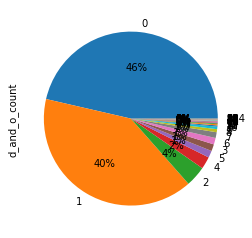

In [28]:
# The D&O variable is a list of lists, and 3 items in a list = 1 director/officer.
# Not all entities list any directors or officers.
def char_count_excluding_blanks(word):
    # Empty lines often return '\xa0' instead of being blank. Fix that.
    return re.sub('\xa0', '', word)

def count_people(df_row):
    # Return how many directors and officers are listed in the `d_and_o` variable
    if len(df_row.d_and_o) > 3:
        return int(len(df_row.d_and_o) / 3)
    first_list = [len(char_count_excluding_blanks(item)) for item in df_row.d_and_o]
    char_count = sum(first_list)
    if char_count:
        return 1
    return 0

df['d_and_o_count'] = df.apply(count_people, axis=1)
df.d_and_o_count.value_counts().plot.pie(autopct='%1.0f%%')

In [29]:
# The number of officers listed is strange. It doesn't follow any discernable distribution,
# and my guess for that is that different companies have different definitions of what it means
# to be a director or officer. One company listed 120+ D&Os, while many only list senior officers.
# There are several ways to explore this. For now I'm going to split it up as whether an entity
# lists 1 or >1 D&O. It may be worthwhile to also have a variable for >2 & >3 D&Os, but I imagine
# the variable's value falls of quickly around that point.
df["gt_one_officer"] = np.where(df.d_and_o_count > 1, 1, 0)
df.gt_one_officer.describe()

count    43658.000000
mean         0.134752
std          0.341462
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: gt_one_officer, dtype: float64

### The dataframe is too big in terms of memory. Shrink the dataframe's memory requirement.

In [30]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43658 entries, 0 to 43683
Columns: 443 entries, Comments to gt_one_officer
dtypes: float64(2), int32(2), int64(397), object(23), uint8(19)
memory usage: 173.0 MB


In [31]:
# Convert the data types to types that use less memory
for var in new_variable_list:
    df[var] = df[var].astype('bool')
for var in entity_dummies.columns:
    df[var] = df[var].astype('bool')
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43658 entries, 0 to 43683
Columns: 443 entries, Comments to gt_one_officer
dtypes: bool(415), float64(2), int32(2), int64(1), object(23)
memory usage: 57.6 MB


### Split into 2 dataframes: one where there was information given for their D&Os, and another where there wasn't

In [32]:
df_w_officers = df[df['d_and_o_count'] >= 1]
df_no_officers = df[df['d_and_o_count'] == 0]
print("With officers:", df_w_officers.shape)
print("No officer info:", df_no_officers.shape)

With officers: (23404, 443)
No officer info: (20254, 443)


# Step 2: regression time

In [33]:
vars_to_exclude = ['EntityName', 'ConsentFlag', 'Comments', 'EffectiveDate', 'EntityType',
                   'IDNumber', 'InactiveDate', 'NIACS', 'OrganisationDate', 
                   'PrincipleCity', 'PrincipleZip', 'PrincipleState', 'PrincipleCountry', 'PrincipleStreet',
                   'ResidentAgentFlag', 'ResidentAgentName', 'ResidentCity', 'ResidentState',
                   'ResidentCountry', 'ResidentZip', 'ResidentStreet',
                   'poisson_d_and_o', 'd_and_o_count', 'officers_listed',
                   'stock_info', 'd_and_o', '(ma)**', '(de)**', '**merg', '12/31/88',
                   'log_time_in_business', 'time_in_business', 'log_censored_tib',
                   'InactiveDate', 'OrganisationDate',
                   'Foreign Corporation']
                    ## **merg is definitely a variable to come back & look at

explanatory_variables = list(set(df.columns) - set(vars_to_exclude))
explanatory_variables.sort()
print(len(explanatory_variables))

413


In [34]:
## There will be some variables that aren't in both datasets. Find them!
explanatory_vars_w_officers = [item for item in explanatory_variables if len(df_w_officers[item].unique()) > 1]
explanatory_vars_no_officers = [item for item in explanatory_variables if len(df_no_officers[item].unique()) > 1]

print("With, w/o officers:", len(explanatory_vars_w_officers), len(explanatory_vars_no_officers))

With, w/o officers: 403 408


In [35]:
# train_test_split
X_train_officers, X_test_officers, y_train_officers, y_test_officers = train_test_split(
                                                    df_w_officers[explanatory_vars_w_officers],
                                                    df_w_officers['log_censored_tib'],
                                                    test_size=0.2,
                                                    random_state=5)

X_train_no_officers, X_test_no_officers, y_train_no_officers, y_test_no_officers = train_test_split(
                                                    df_no_officers[explanatory_vars_no_officers],
                                                    df_no_officers['log_censored_tib'],
                                                    test_size=0.2,
                                                    random_state=5)

In [36]:
# Remove 'is_tib_censored' from the test/train data in a way that keeps both sets usable
X_train_officers2 = X_train_officers[X_train_officers.columns.difference(['is_tib_censored'])]

In [37]:
# Test on a very reduced dataset:
smaller_officers = copy.deepcopy(df_w_officers)
X_train_officers, X_test_officers, y_train_officers, y_test_officers = train_test_split(
                                                    smaller_officers[explanatory_vars_w_officers],
                                                    smaller_officers['log_censored_tib'],
                                                    test_size=0.2,
                                                    random_state=5)

#smaller_vars_w_officers = [item for item in explanatory_vars_w_officers if len(X_train_officers[item].unique()) > 1]
smaller_vars_w_officers = [item for item in explanatory_vars_w_officers \
                           if len(X_train_officers[:15000][item].unique()) > 1]



### WHAT I'M DOING HERE DOESN'T MAKE SENSE.
## Why would the random split be the same for the first X_train_ vs the 2nd?
## Does the same random_state guarantee the same split? Seems it should...
## Why is there often an issue with 'Bank', the first item?



var_size = 15
if 'is_tib_censored' not in smaller_vars_w_officers[:var_size]:
    tiny_vars = smaller_vars_w_officers[:var_size] + ['is_tib_censored']
else:
    tiny_vars = smaller_vars_w_officers[:var_size]
#tiny_vars += smaller_vars_w_officers[38:40]

X_train_officers, X_test_officers, y_train_officers, y_test_officers = train_test_split(
                                                    smaller_officers[tiny_vars],
                                                    smaller_officers['log_censored_tib'],
                                                    test_size=0.2,
                                                    random_state=5)
X_train_officers2 = X_train_officers[X_train_officers.columns.difference(['is_tib_censored'])]
#X_train_officers2 = X_train_officers[smaller_vars_w_officers]

In [40]:
#X_train_officers2[pd.isnull(X_train_officers).any(axis=1)]
print(X_train_officers2.shape)
print(X_train_officers.shape)

for item in X_train_officers2.columns:
#for item in explanatory_vars_w_officers:
    print(item)

### Try skipping this variable to confirm the problem is with the variable.
### list_[0:35] + list_[37:40]

#print(smaller_vars_w_officers[35])
#smaller_officers.automot.value_counts()

(18723, 20)
(18723, 21)
Bank
Domestic Non-Profit Corporation
Domestic Profit Corporation
Foreign Non-Profit Corporation
Insurance
Loan and Investment
Non-Profit Producers' Cooperative
Professional Service Corporation
Transportation
accessori
account
acquir
acquisit
act
activ
administr
advanc
advertis
agenc
agent


In [39]:
sf_officers = sm.duration.PHReg(
    y_train_officers[:15000],
    X_train_officers2[:15000].astype(float),
    status=X_train_officers[:15000].is_tib_censored)
officers_result = sf_officers.fit()
officers_result.summary()

c:\users\aubre\desktop\github_math\git_math\lib\site-packages\statsmodels\duration\hazard_regression.py:811: RuntimeWarning: invalid value encountered in true_divide
  hess += m*(xp2 / xp0  - np.outer(xp1, xp1) / xp0**2)
c:\users\aubre\desktop\github_math\git_math\lib\site-packages\statsmodels\duration\hazard_regression.py:697: RuntimeWarning: invalid value encountered in true_divide
  grad += (exog_s[ix,:] - xp1 / xp0).sum(0)
c:\users\aubre\desktop\github_math\git_math\lib\site-packages\statsmodels\base\optimizer.py:271: RuntimeWarning: invalid value encountered in greater
  oldparams) > tol)):
c:\users\aubre\desktop\github_math\git_math\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
c:\users\aubre\desktop\github_math\git_math\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
c:\users\aub

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                Results: PHReg
==============================================================================
Model:                       PH Reg                  Sample size:        15000
Dependent variable:          log_censored_tib        Num. events:        11197
Ties:                        Breslow                                          
------------------------------------------------------------------------------
                                  log HR log HR SE  HR  t  P>|t| [0.025 0.975]
------------------------------------------------------------------------------
Bank                                 nan       nan nan nan   nan    nan    nan
Domestic Non-Profit Corporation      nan       nan nan nan   nan    nan    nan
Domestic Profit Corporation          nan       nan nan nan   nan    nan    nan
Foreign Non-Profit Corporation       nan       nan nan nan   nan    nan    nan
Insurance                            nan       nan nan nan   nan    nan    nan
Loan and Investment                  nan       nan nan nan   nan    nan    nan
Non-Profit Producers' Cooperative    nan       nan nan nan   nan    nan    nan
Professional Service Corporation     nan       nan nan nan   nan    nan    nan
Transportation                       nan       nan nan nan   nan    nan    nan
accessori                            nan       nan nan nan   nan    nan    nan
account                              nan       nan nan nan   nan    nan    nan
acquir                               nan       nan nan nan   nan    nan    nan
acquisit                             nan       nan nan nan   nan    nan    nan
act                                  nan       nan nan nan   nan    nan    nan
activ                                nan       nan nan nan   nan    nan    nan
administr                            nan       nan nan nan   nan    nan    nan
advanc                               nan       nan nan nan   nan    nan    nan
advertis                             nan       nan nan nan   nan    nan    nan
agenc                                nan       nan nan nan   nan    nan    nan
agent                                nan       nan nan nan   nan    nan    nan
==============================================================================
Confidence intervals are for the hazard ratios
"""

In [ ]:
sf_officers = sm.duration.PHReg(y_train_officers, X_train_officers2.astype(float), status=X_train_officers.is_tib_censored)
officers_result = sf_officers.fit()
officers_result.summary()

In [ ]:
for item in X_train_officers2.columns:
    print(item)

In [ ]:
#df[df.isnull().any(axis=1)]
#df_w_officers[explanatory_variables][df_w_officers[explanatory_variables].isnan().any(axis=1)]
#df[pd.isnull(df).any(axis=1)]
X_train_officers.shape

In [ ]:
# Loss function: squared error isn't appropriate. What are my options for survival regressions?
# Is that even a thing for survival regressions? If so, can I use quantile/absolute error?

# Don't forget to make ROC curves for all the predictions!